# Atividade - Economia Regional e Urbana - Análise de Minas Gerais

- Estatística I de Moran
- Gráfico de dispersão de Moran
- Gráfico de dispersão de Moran Bivariado
- Gráfico LISA (Moran Local Univariado) (Gráfico de Clusters)
- Gráfico LISA (Moran Local Bivariado)

In [1]:
import geopandas
import pygeoda
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# colors = [#F4663A, #7A306C, #8E8DBE, #9EBC9E, #F1DAC4, #EAE8DB, #333229]
# sns.set_palette(sns.color_palette("flare"))

c:\Users\vitor\OneDrive\FEAUSP\economia-regional-e-urbana\env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\vitor\AppData\Local\Temp\ipykernel_4672\1457698092.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0

## Tratamento dos Dados

In [3]:
gdf = geopandas.read_file("dados/MG/MG_Extra.shp")

gdf.head()

,WGDPPC_14,CODMUN6,MUNIC_PIO,SEM_ACENTO,MUNIC_PI0,UF,UF_IBGE,REGI_O,MESO_IBGE,MESO_IBG0,...,VAAGR_05,VAIND_05,VASER_05,VAAGR_06,VAIND_06,VASER_06,VAAGR_07,VAIND_07,VASER_07,geometry
0,34835.8900,311455,CARNEIRINHO,CARNEIRINHO,3114550,MG,31,SE,TRIANGULO MINEIRO/ALTO PARANAIBA,05,...,46922.070,6377.722,39336.869,42863.058,6953.932,43272.796,52149.078,7389.286,51212.480,"POLYGON ((-51.03577 -19.79163, -51.03520 -19.7..."
1,29214.4725,313862,LIMEIRA DO OESTE,LIMEIRA DO OESTE,3138625,MG,31,SE,TRIANGULO MINEIRO/ALTO PARANAIBA,05,...,32148.750,10199.422,23479.776,42270.204,21126.180,30415.137,41425.921,21105.053,33858.511,"POLYGON ((-50.82957 -19.31027, -50.82790 -19.3..."
2,21563.3220,315980,SANTA VITÓRIA,SANTA VITORIA,3159803,MG,31,SE,TRIANGULO MINEIRO/ALTO PARANAIBA,05,...,55999.459,15091.408,73108.186,47495.800,15477.086,76642.051,53577.919,19254.704,81500.439,"POLYGON ((-50.74148 -19.21245, -50.74271 -19.1..."
3,24282.1420,313440,ITURAMA,ITURAMA,3134400,MG,31,SE,TRIANGULO MINEIRO/ALTO PARANAIBA,05,...,76597.141,146206.852,190102.107,80725.959,146622.569,214989.059,76986.762,143021.728,239962.673,"POLYGON ((-50.69102 -19.57251, -50.68522 -19.5..."
4,29868.8600,317043,UNIÃO DE MINAS,UNIAO DE MINAS,3170438,MG,31,SE,TRIANGULO MINEIRO/ALTO PARANAIBA,05,...,36966.971,4535.320,16353.524,36768.338,3175.939,17880.960,42331.427,4128.241,19740.676,"POLYGON ((-50.51562 -19.27241, -50.51452 -19.2..."


In [134]:
paths = [r"dados/Base_Dados_PIB_dos_Municipios_1999_2002/05 05 2005 Base Dados Ajustada PIB dos Municípios 1999-2002.xls",
         r"dados/Base_Dados_PIB_dos_Municipios_2003_2007/base.xls"]

for file in paths:
    
    df = pd.read_excel(file, dtype={"cod_munic": str, "cod_uf": str})

    df = df.rename({name: str(name).upper() for name in df.columns}, axis=1)
    df = df[["ANO", "COD_UF", "COD_MUNIC", "AGRO", "IND", "SERV"]].query("COD_UF == '31'")

  
    for ano in df["ANO"].unique():
        filler_ano = str(ano)[-2:]
        df_y = df[df["ANO"] == ano].drop(["ANO", "COD_UF"], axis=1).rename({"AGRO": f"VAAGR_{filler_ano}", 
                                                                            "IND": f"VAIND_{filler_ano}", 
                                                                            "SERV": f"VASER_{filler_ano}", 
                                                                            "COD_MUNIC": "MUNIC_PI0"}, axis=1)
        
        gdf = pd.merge(gdf, df_y, how="left", on="MUNIC_PI0")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [105]:
# gdf.to_file("dados/MG_Extra.shp")

## Estatística I de Moran e Gráfico de Dispersão

In [4]:
mg = pygeoda.open(gdf)
queen_w = pygeoda.queen_weights(mg)

In [155]:
# ('#eeeeee', '#b2182b', '#ef8a62', '#fddbc7', '#67adc7', '#464646', '#999999')

def graph(gdf, var, title: str):
    
    fig, ax = plt.subplots(figsize=(10, 10))

    # lisa_colors = var.lisa_colors()
    lisa_colors = ("#eeeeee", "#F55A2A", "#542E60", "#b483c3", "#f8835f", "#464646", "#999999")
    lisa_labels = var.lisa_labels()

    # attach LISA cluster indicators to geodataframe
    gdf["LISA_CLUSTERS"] = var.lisa_clusters()

    for ctype, data in gdf.groupby("LISA_CLUSTERS"):
        color = lisa_colors[ctype]
        lbl = lisa_labels[ctype]
        data.plot(color=color, 
                ax=ax, 
                label=lbl, 
                edgecolor="black", 
                linewidth=0.2)

    # Place legend in the lower right hand corner of the plot
    # lisa_legend = [matplotlib.lines.Line2D([0], [0], color=color, lw=2) for color in lisa_colors]
    # ax.legend(lisa_legend, lisa_labels, loc="lower left", fontsize=10, frameon=True)
    ax.set(title=title)
    ax.set_axis_off()

In [5]:
# Variáveis que serão utlizadas
GDPPC_99 = pygeoda.local_moran(queen_w, gdf['GDPPC_99'], permutations=9999)
GDPPC_14 = pygeoda.local_moran(queen_w, gdf['GDPPC_14'], permutations=9999)

VAAGR_99 = pygeoda.local_moran(queen_w, gdf['VAAGR_99'], permutations=9999)
VAAGR_14 = pygeoda.local_moran(queen_w, gdf['VAAGR_14'], permutations=9999)

VAIND_99 = pygeoda.local_moran(queen_w, gdf['VAIND_99'], permutations=9999)
VAIND_14 = pygeoda.local_moran(queen_w, gdf['VAIND_14'], permutations=9999)

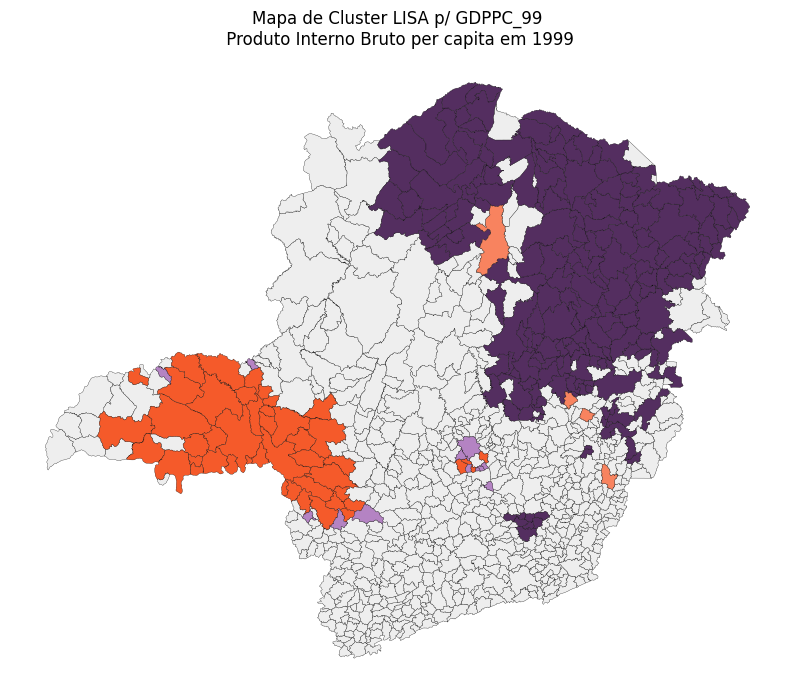

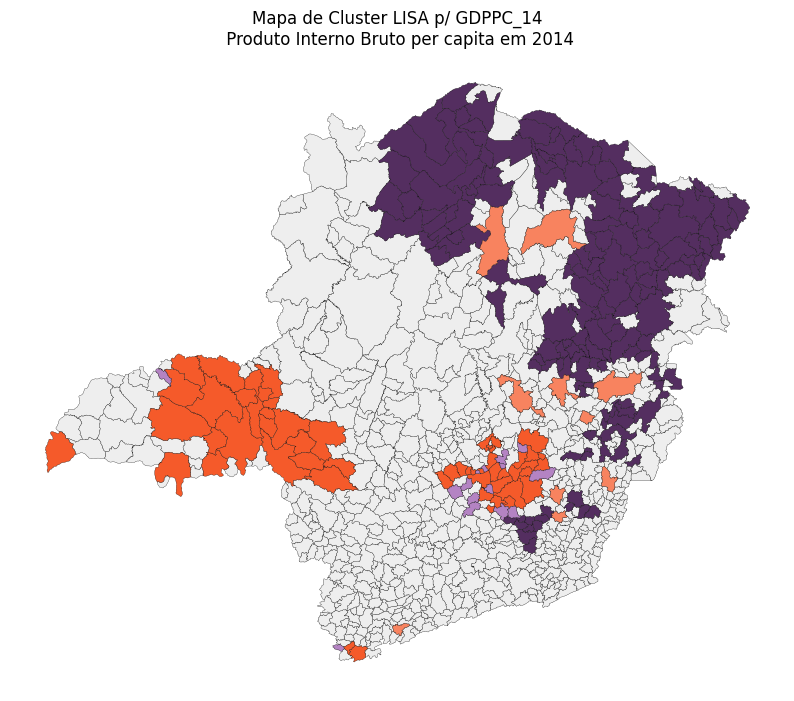

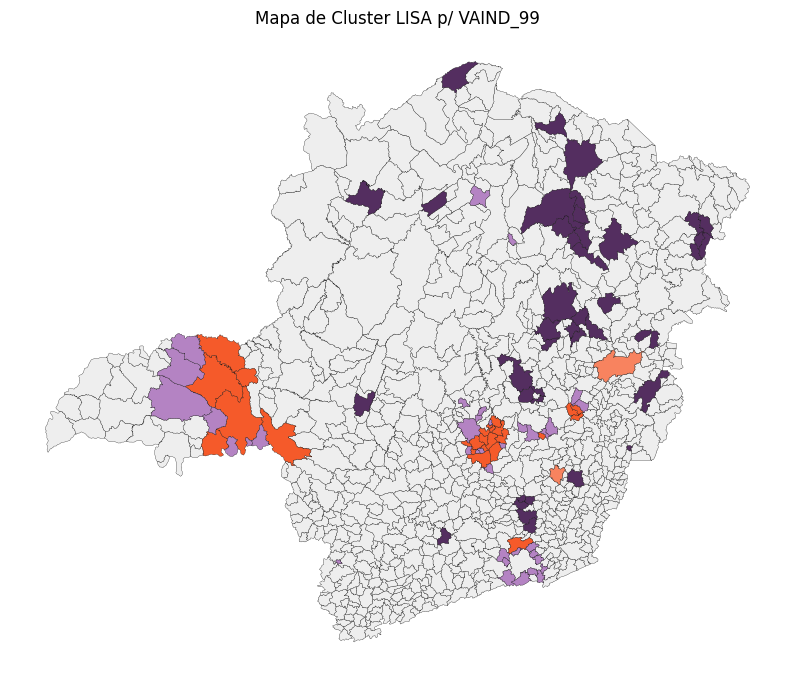

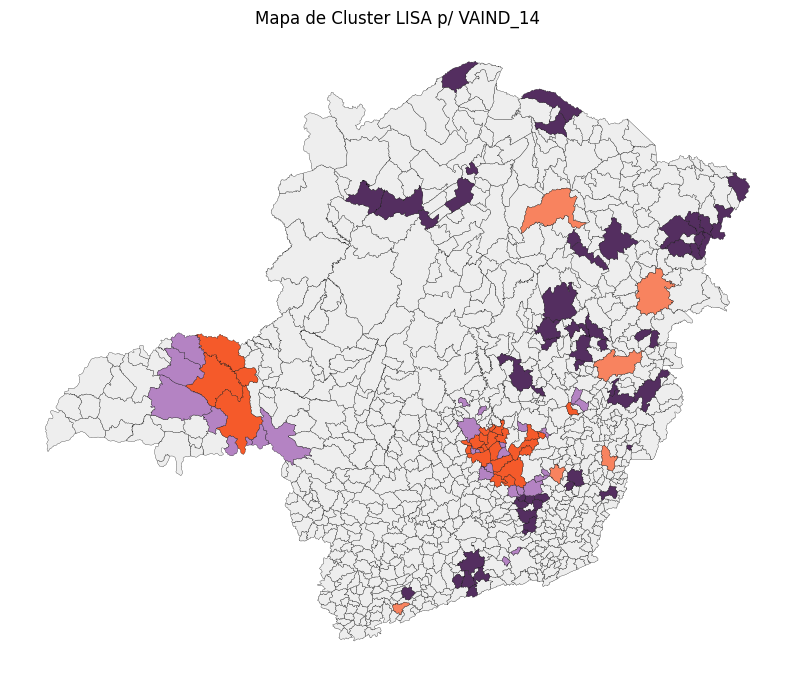

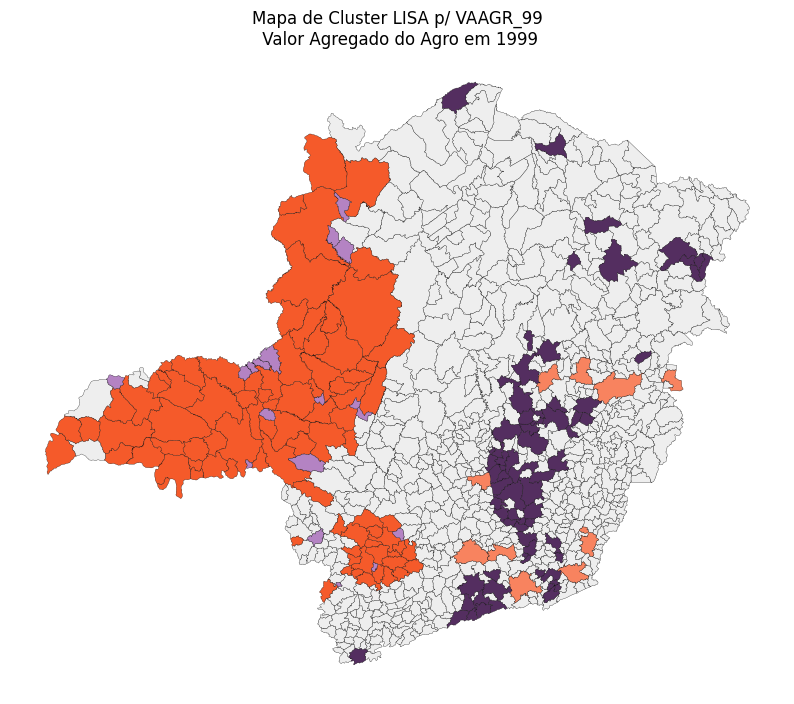

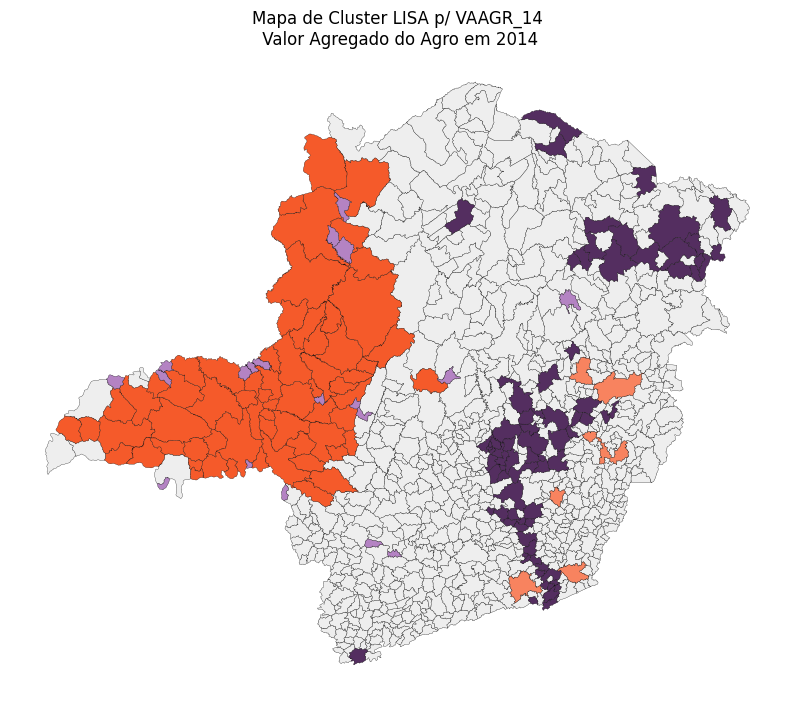

In [156]:
graph(gdf, GDPPC_99, "Mapa de Cluster LISA p/ GDPPC_99\n Produto Interno Bruto per capita em 1999")
graph(gdf, GDPPC_14, "Mapa de Cluster LISA p/ GDPPC_14\n Produto Interno Bruto per capita em 2014")

graph(gdf, VAIND_99, "Mapa de Cluster LISA p/ VAIND_99")
graph(gdf, VAIND_14, "Mapa de Cluster LISA p/ VAIND_14")

graph(gdf, VAAGR_99, "Mapa de Cluster LISA p/ VAAGR_99\n Valor Agregado do Agro em 1999")
graph(gdf, VAAGR_14, "Mapa de Cluster LISA p/ VAAGR_14\n Valor Agregado do Agro em 2014")

In [145]:
# colors = ("#eeeeee",         "#F55A2A",   "#542E60", "#b483c3,  "#f8835f",  "#464646",   "#999999")
# labels = ("Not significant", "High-High", "Low-Low", "Low-High", "High-Low", "Undefined", "Isolated")
print(GDPPC_14.lisa_colors())
print(GDPPC_14.lisa_labels())

('#eeeeee', '#FF0000', '#0000FF', '#a7adf9', '#f4ada8', '#464646', '#999999')
('Not significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low', 'Undefined', 'Isolated')


In [6]:
# ('#eeeeee', '#b2182b', '#ef8a62', '#fddbc7', '#67adc7', '#464646', '#999999')

def graph(ax, gdf, var, title: str):
    """Function to plot clusters maps in a Matplotlib axes."""

    # lisa_colors = var.lisa_colors()
    lisa_colors = ("#eeeeee", "#F55A2A", "#542E60", "#b483c3", "#f8835f", "#464646", "#999999")
    lisa_labels = var.lisa_labels()

    # attach LISA cluster indicators to geodataframe
    gdf["LISA_CLUSTERS"] = var.lisa_clusters()

    for ctype, data in gdf.groupby("LISA_CLUSTERS"):
        color = lisa_colors[ctype]
        lbl = lisa_labels[ctype]
        data.plot(color=color, 
                ax=ax, 
                label=lbl, 
                edgecolor="black", 
                linewidth=0.2)

    # Place legend in the lower right hand corner of the plot
    # lisa_legend = [matplotlib.lines.Line2D([0], [0], color=color, lw=2) for color in lisa_colors]
    # ax.legend(lisa_legend, lisa_labels, loc="lower left", fontsize=10, frameon=True)
    ax.set(title=title)
    ax.set_axis_off()

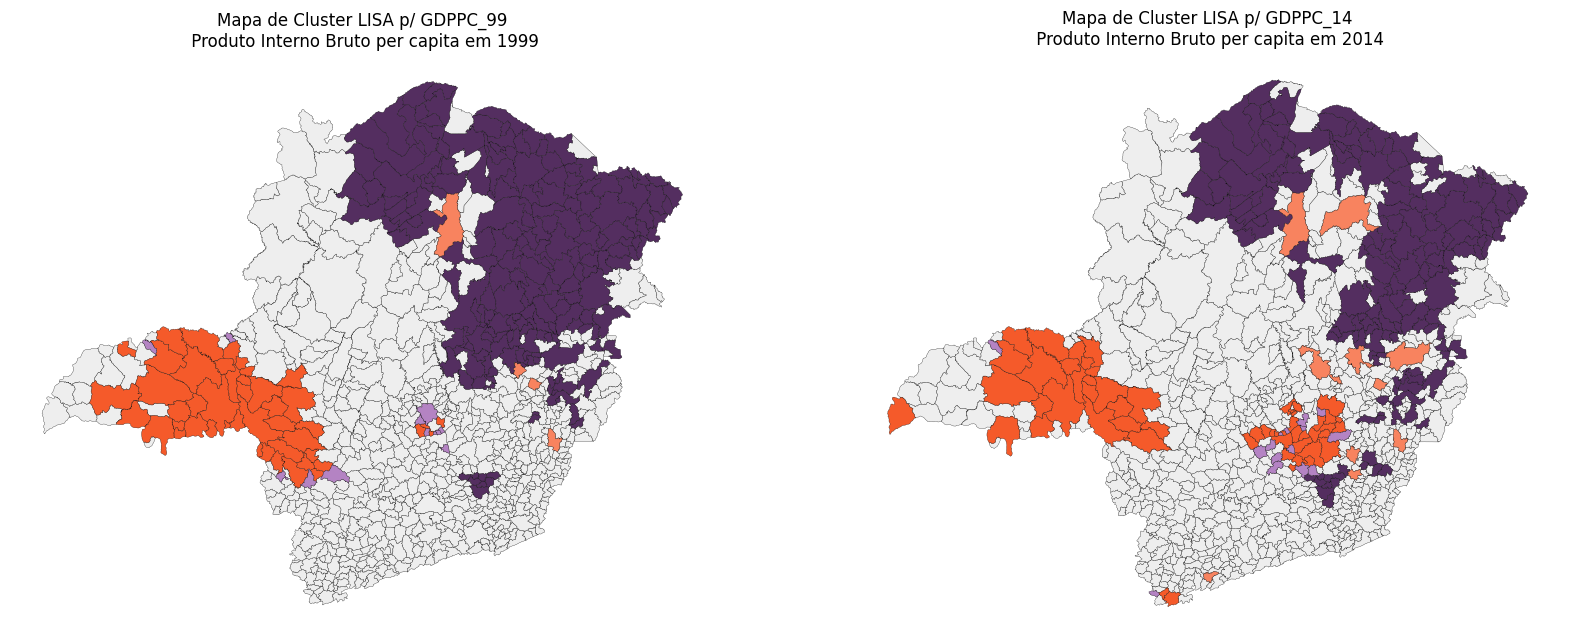

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

graph(ax1, gdf, GDPPC_99, "Mapa de Cluster LISA p/ GDPPC_99\n Produto Interno Bruto per capita em 1999")
graph(ax2, gdf, GDPPC_14, "Mapa de Cluster LISA p/ GDPPC_14\n Produto Interno Bruto per capita em 2014")

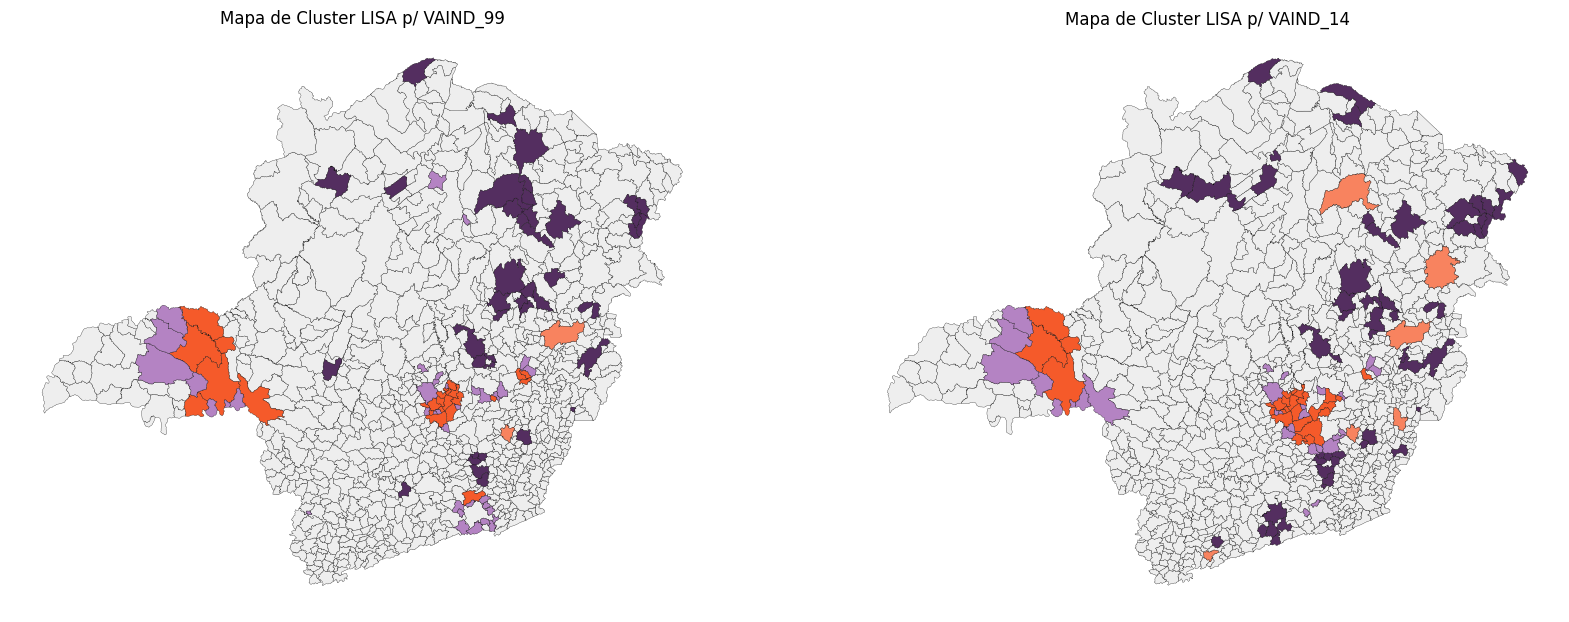

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

graph(ax1, gdf, VAIND_99, "Mapa de Cluster LISA p/ VAIND_99")
graph(ax2, gdf, VAIND_14, "Mapa de Cluster LISA p/ VAIND_14")

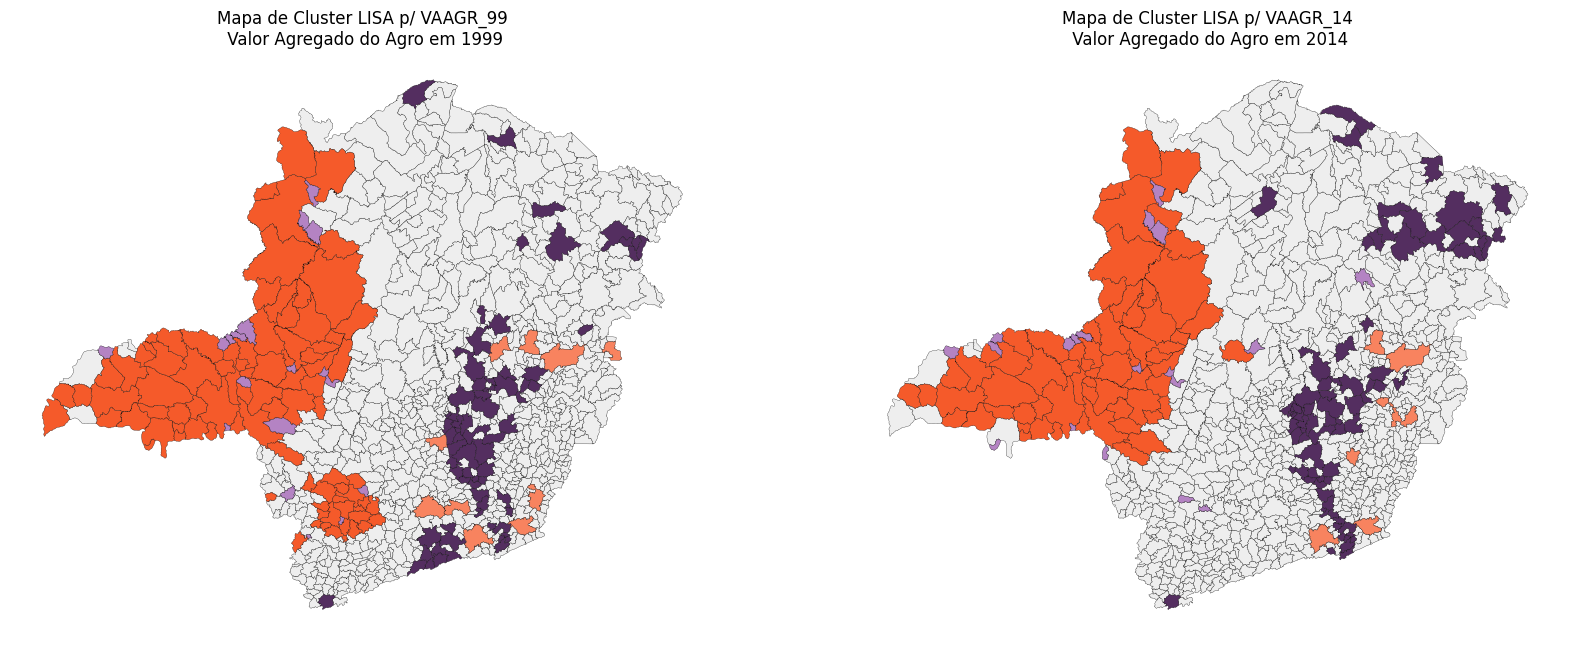

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

graph(ax1, gdf, VAAGR_99, "Mapa de Cluster LISA p/ VAAGR_99\n Valor Agregado do Agro em 1999")
graph(ax2, gdf, VAAGR_14, "Mapa de Cluster LISA p/ VAAGR_14\n Valor Agregado do Agro em 2014")